### Feature Impacts on Noisy Data
We will generate data points randomly for both training and test sets, and see if our feature tracking methods can help in a model's training phase when data is extremely noisy.

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from helper_plots import plot_feature_importances_per_iter, plot_feature_impacts_per_iter, plot_feature_gradients_per_iter, plot_total_feature_impacts, plot_prediction_feature_impacts

In [36]:
np.random.seed(42)

n_samples = 1000
X_noisy = np.random.randn(n_samples, 14)
# Generate 1 predictive feature - linearly related to target var but with some noise
X_predictive = np.linspace(0, 10, n_samples) + np.random.normal(0, 1, n_samples)
X = np.hstack((X_noisy, X_predictive.reshape(-1, 1)))
y = X_predictive * 2 + np.random.normal(0, 1, n_samples)

df = pd.DataFrame(X, columns=[f'feature_{i+1}' for i in range(15)])
feature_name_mappings = {i: f'feature_{i+1}' for i in range(15)}
df['target'] = y

X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=42)



In [37]:
from feature_tracker import CustomGBR
# Train CustomGBR with early stopping
gbr = CustomGBR(n_estimators=500, learning_rate=0.1, max_depth=3, validation_fraction=0.2, n_iter_no_change=10, tol=0.01, random_state=42)
gbr.fit(X_train, y_train)
print(f'gbr fit with {gbr.n_estimators_} estimators from early stopping')

gbr fit with 51 estimators from early stopping


#### Comparing feature tracking vs traditional early stopping methods

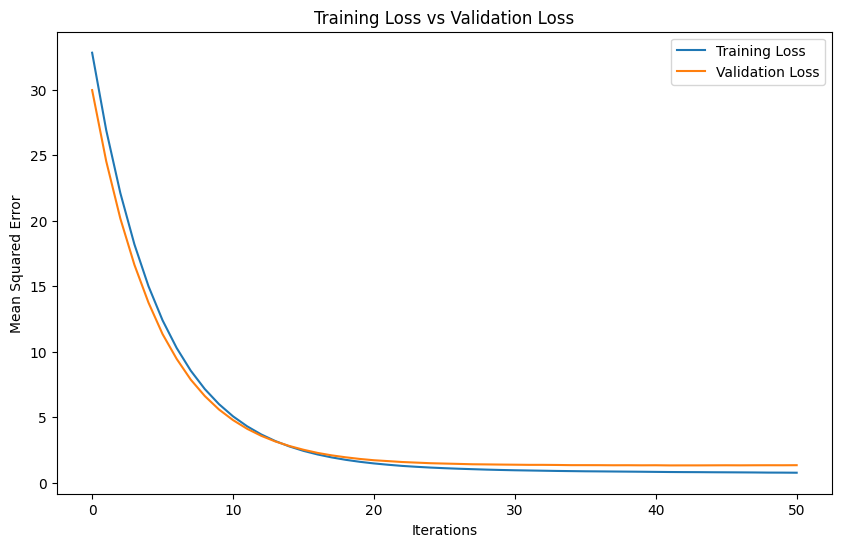

In [38]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

mse_train = [mean_squared_error(y_train, y_pred) for y_pred in gbr.staged_predict(X_train)]
mse_test = [mean_squared_error(y_test, y_pred) for y_pred in gbr.staged_predict(X_test)]

# Plotting the training loss vs. validation loss
plt.figure(figsize=(10, 6))
plt.plot(mse_train, label='Training Loss')
plt.plot(mse_test, label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

#### Normal Feature Importances

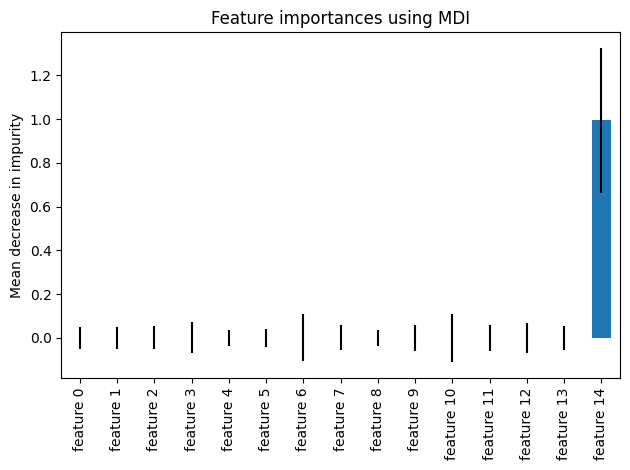

In [39]:
importances = gbr.feature_importances_
std = np.std([tree[0].feature_importances_ for tree in gbr.estimators_], axis=0)
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

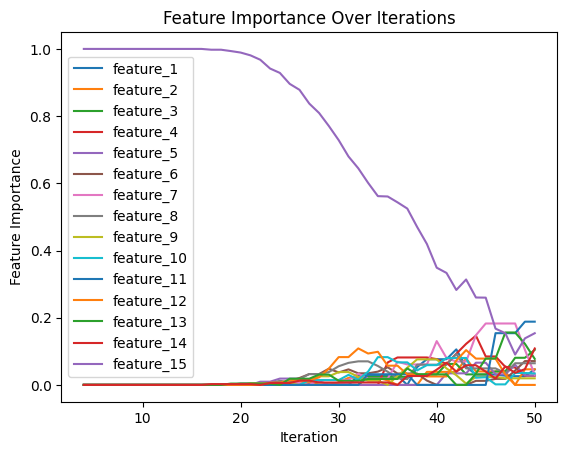

In [40]:
feature_importances_per_iter = gbr.get_feature_importance_per_iteration()
plot_feature_importances_per_iter(feature_importances_per_iter, feature_name_mappings=feature_name_mappings)

As observed, the feature impact of the only predictive feature (feature_15) starts to account for very little feature importance after iteration 40. We will try to restrict and set a threshold to make sure feature_15 still accounts for 1/3 of the total feature importance for every new weak learner created.

In [41]:
def get_feature_importance_early_stopping_iter(feature_importances_df, feature_idx, threshold=0.1, n_iter_no_change=10):
    df_feature_per_iter = pd.DataFrame(feature_importances_df[feature_idx])
    df_feature_per_iter['rolling_max_importance'] = df_feature_per_iter[feature_idx].rolling(n_iter_no_change).max()
    df_below_thresh = df_feature_per_iter[df_feature_per_iter['rolling_max_importance'] < threshold]
    assert len(df_below_thresh) > 1, f'There are no iterations where feature {feature_idx} is below the threshold importance'
    return min(df_below_thresh.index)
    
print(f' Early stopping by feature impact at iteration:',
      f'{get_feature_importance_early_stopping_iter(feature_importances_per_iter, 14, threshold=0.33, n_iter_no_change=3)}')

 Early stopping by feature impact at iteration: 40


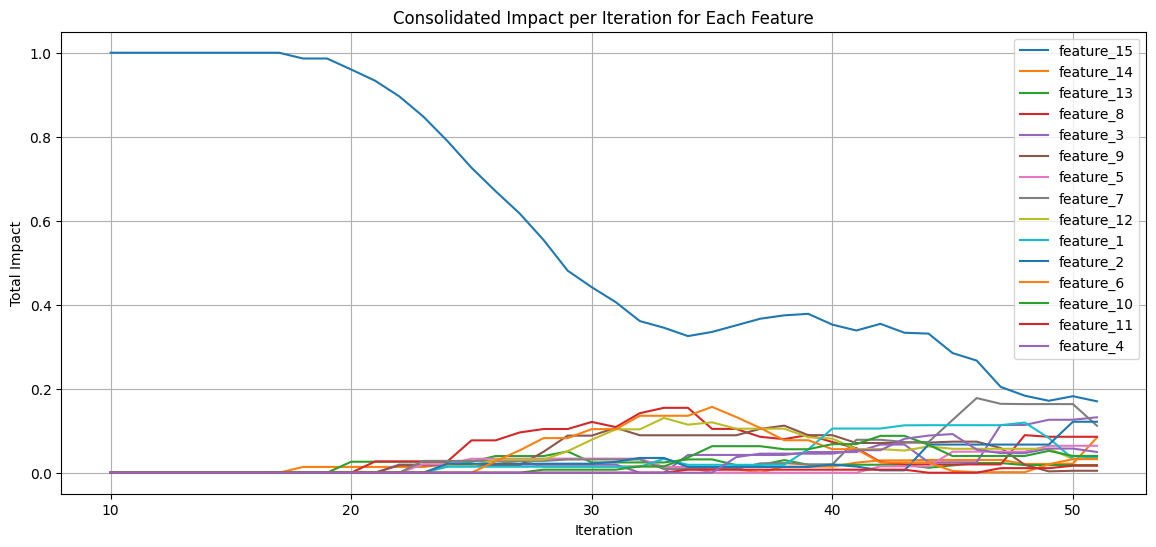

In [42]:
feature_impacts_per_iter = gbr.get_feature_impacts_per_iteration(directional=False, normalized=True, weighted_by_samples=True, n_samples=n_samples)
plot_feature_impacts_per_iter(feature_impacts_per_iter, feature_name_mappings=feature_name_mappings)

Feature Impats portray a similar result, however after iteration 30, the impacts from feature_15 seems to be on par with a few of the either dummy features.

In [43]:
feature_impacts_per_iter

,feature,iteration,impact,normalized_impact,samples
117,14,1,1.764218,1.000000,184
118,14,2,1.598703,1.000000,161
119,14,3,1.453449,1.000000,640
120,14,4,1.317456,1.000000,295
121,14,5,1.187510,1.000000,88
...,...,...,...,...,...
20,2,51,0.028972,0.059166,143
53,6,51,0.035424,0.072343,330
116,13,51,0.351525,0.717885,345
7,0,51,0.018564,0.037911,640


In [44]:
def get_feature_impact_early_stopping_iter(feature_impacts_df, feature_idx, n_samples, 
                                           impact_direction=1, threshold=0.01, n_iter_no_change=2):

    df = pd.DataFrame(feature_impacts_df[feature_impacts_df['feature'] == feature_idx])
    df_feature_per_iter = df.groupby('iteration').sum()
    df_feature_per_iter['rolling_max_impact'] = df_feature_per_iter['normalized_impact'].rolling(n_iter_no_change).max()
    df_below_thresh = df_feature_per_iter[df_feature_per_iter['rolling_max_impact'] < threshold]
    assert len(df_below_thresh) > 0, f'There is no impact below the threshold for feature index {feature_idx}.'
    return min(df_below_thresh.index)
    
print(f' Early stopping by feature impact at iteration:',
      f'{get_feature_impact_early_stopping_iter(feature_impacts_per_iter, 14, n_samples, threshold=0.25)}')

 Early stopping by feature impact at iteration: 41


#### Comparing model performances using early stopping with feature importance vs normal early stopping

In [45]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE) for normal early stopping: {mse:.5f}")
print(f"Mean Absolute Error (MAE) for normal early stopping: {mae:.5f}")

Mean Squared Error (MSE) for normal early stopping: 1.32467
Mean Absolute Error (MAE) for normal early stopping: 0.95148


In [46]:
# Train CustomGBR with stopping decided by feature importance tracking
gbr = CustomGBR(n_estimators=41, learning_rate=0.1, max_depth=3, validation_fraction=0.2, n_iter_no_change=10, tol=0.001, random_state=42)
gbr.fit(X_train, y_train)


CustomGBR(n_estimators=41, n_iter_no_change=10, random_state=42, tol=0.001,
          validation_fraction=0.2)

In [47]:
y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE) for feature importance based early stopping: {mse:.5f}")
print(f"Mean Absolute Error (MAE) for feature importance based early stopping: {mae:.5f}")

Mean Squared Error (MSE) for feature importance based early stopping: 1.31990
Mean Absolute Error (MAE) for feature importance based early stopping: 0.94671
